# 04 — Grad-CAM Explainability

Grad-CAM shows **where the model looks** when making predictions. Red/yellow = important regions, blue = ignored.

**How it works:** Compute gradients at the last conv layer → weight feature maps → heatmap of important regions.

---

In [1]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

from src.config import (
    DATA_DIR, MODELS_DIR, RESULTS_DIR, SEED,
    CLASS_NAMES, CLASS_LABELS, NUM_CLASSES,
    IMAGE_SIZE, MODEL_NAME,
)
from src.model import create_model
from src.preprocessing import load_and_preprocess, denormalize
from src.gradcam import GradCAM, overlay_heatmap, visualize_gradcam

plt.rcParams['figure.dpi'] = 120

device = torch.device('cpu')
print('Setup complete!')

Setup complete!


---
## 1. Load Model & Setup Grad-CAM

Attach Grad-CAM to the last conv layer of EfficientNet — it has the richest spatial features.

In [2]:
# Load the trained model
model = create_model(MODEL_NAME, NUM_CLASSES, pretrained=False)
model.load_state_dict(torch.load(MODELS_DIR / 'best_model.pth', map_location=device, weights_only=True))
model = model.to(device)
model.eval()

# For EfficientNet, the last conv layer is in model.conv_head or model.bn2
# We'll use the last block's output (before global pooling)
# timm EfficientNet structure: features (blocks) -> conv_head -> bn2 -> global_pool -> classifier
target_layer = model.bn2  # Last batch norm after the final conv layer

grad_cam = GradCAM(model, target_layer)
print(f'Model loaded: {MODEL_NAME}')
print(f'Grad-CAM target layer: {type(target_layer).__name__}')
print(f'\nGrad-CAM is ready!')

Model loaded: efficientnet_b0
Grad-CAM target layer: BatchNormAct2d

Grad-CAM is ready!


---
## 2. Grad-CAM per Class

For each class: original image | heatmap | overlay with prediction.

In [3]:
from sklearn.model_selection import train_test_split

# Recreate test split
df = pd.read_csv(DATA_DIR / 'HAM10000_metadata.csv')
image_dirs = [
    DATA_DIR / 'HAM10000_images_part_1',
    DATA_DIR / 'HAM10000_images_part_2',
]

train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['dx'], random_state=SEED)

# Build image path lookup
image_path_map = {}
for d in image_dirs:
    if d.exists():
        for f in d.iterdir():
            if f.suffix == '.jpg':
                image_path_map[f.stem] = f

print(f'Test samples: {len(test_df)}')
print(f'Image lookup: {len(image_path_map)} images')

Test samples: 1503
Image lookup: 10015 images


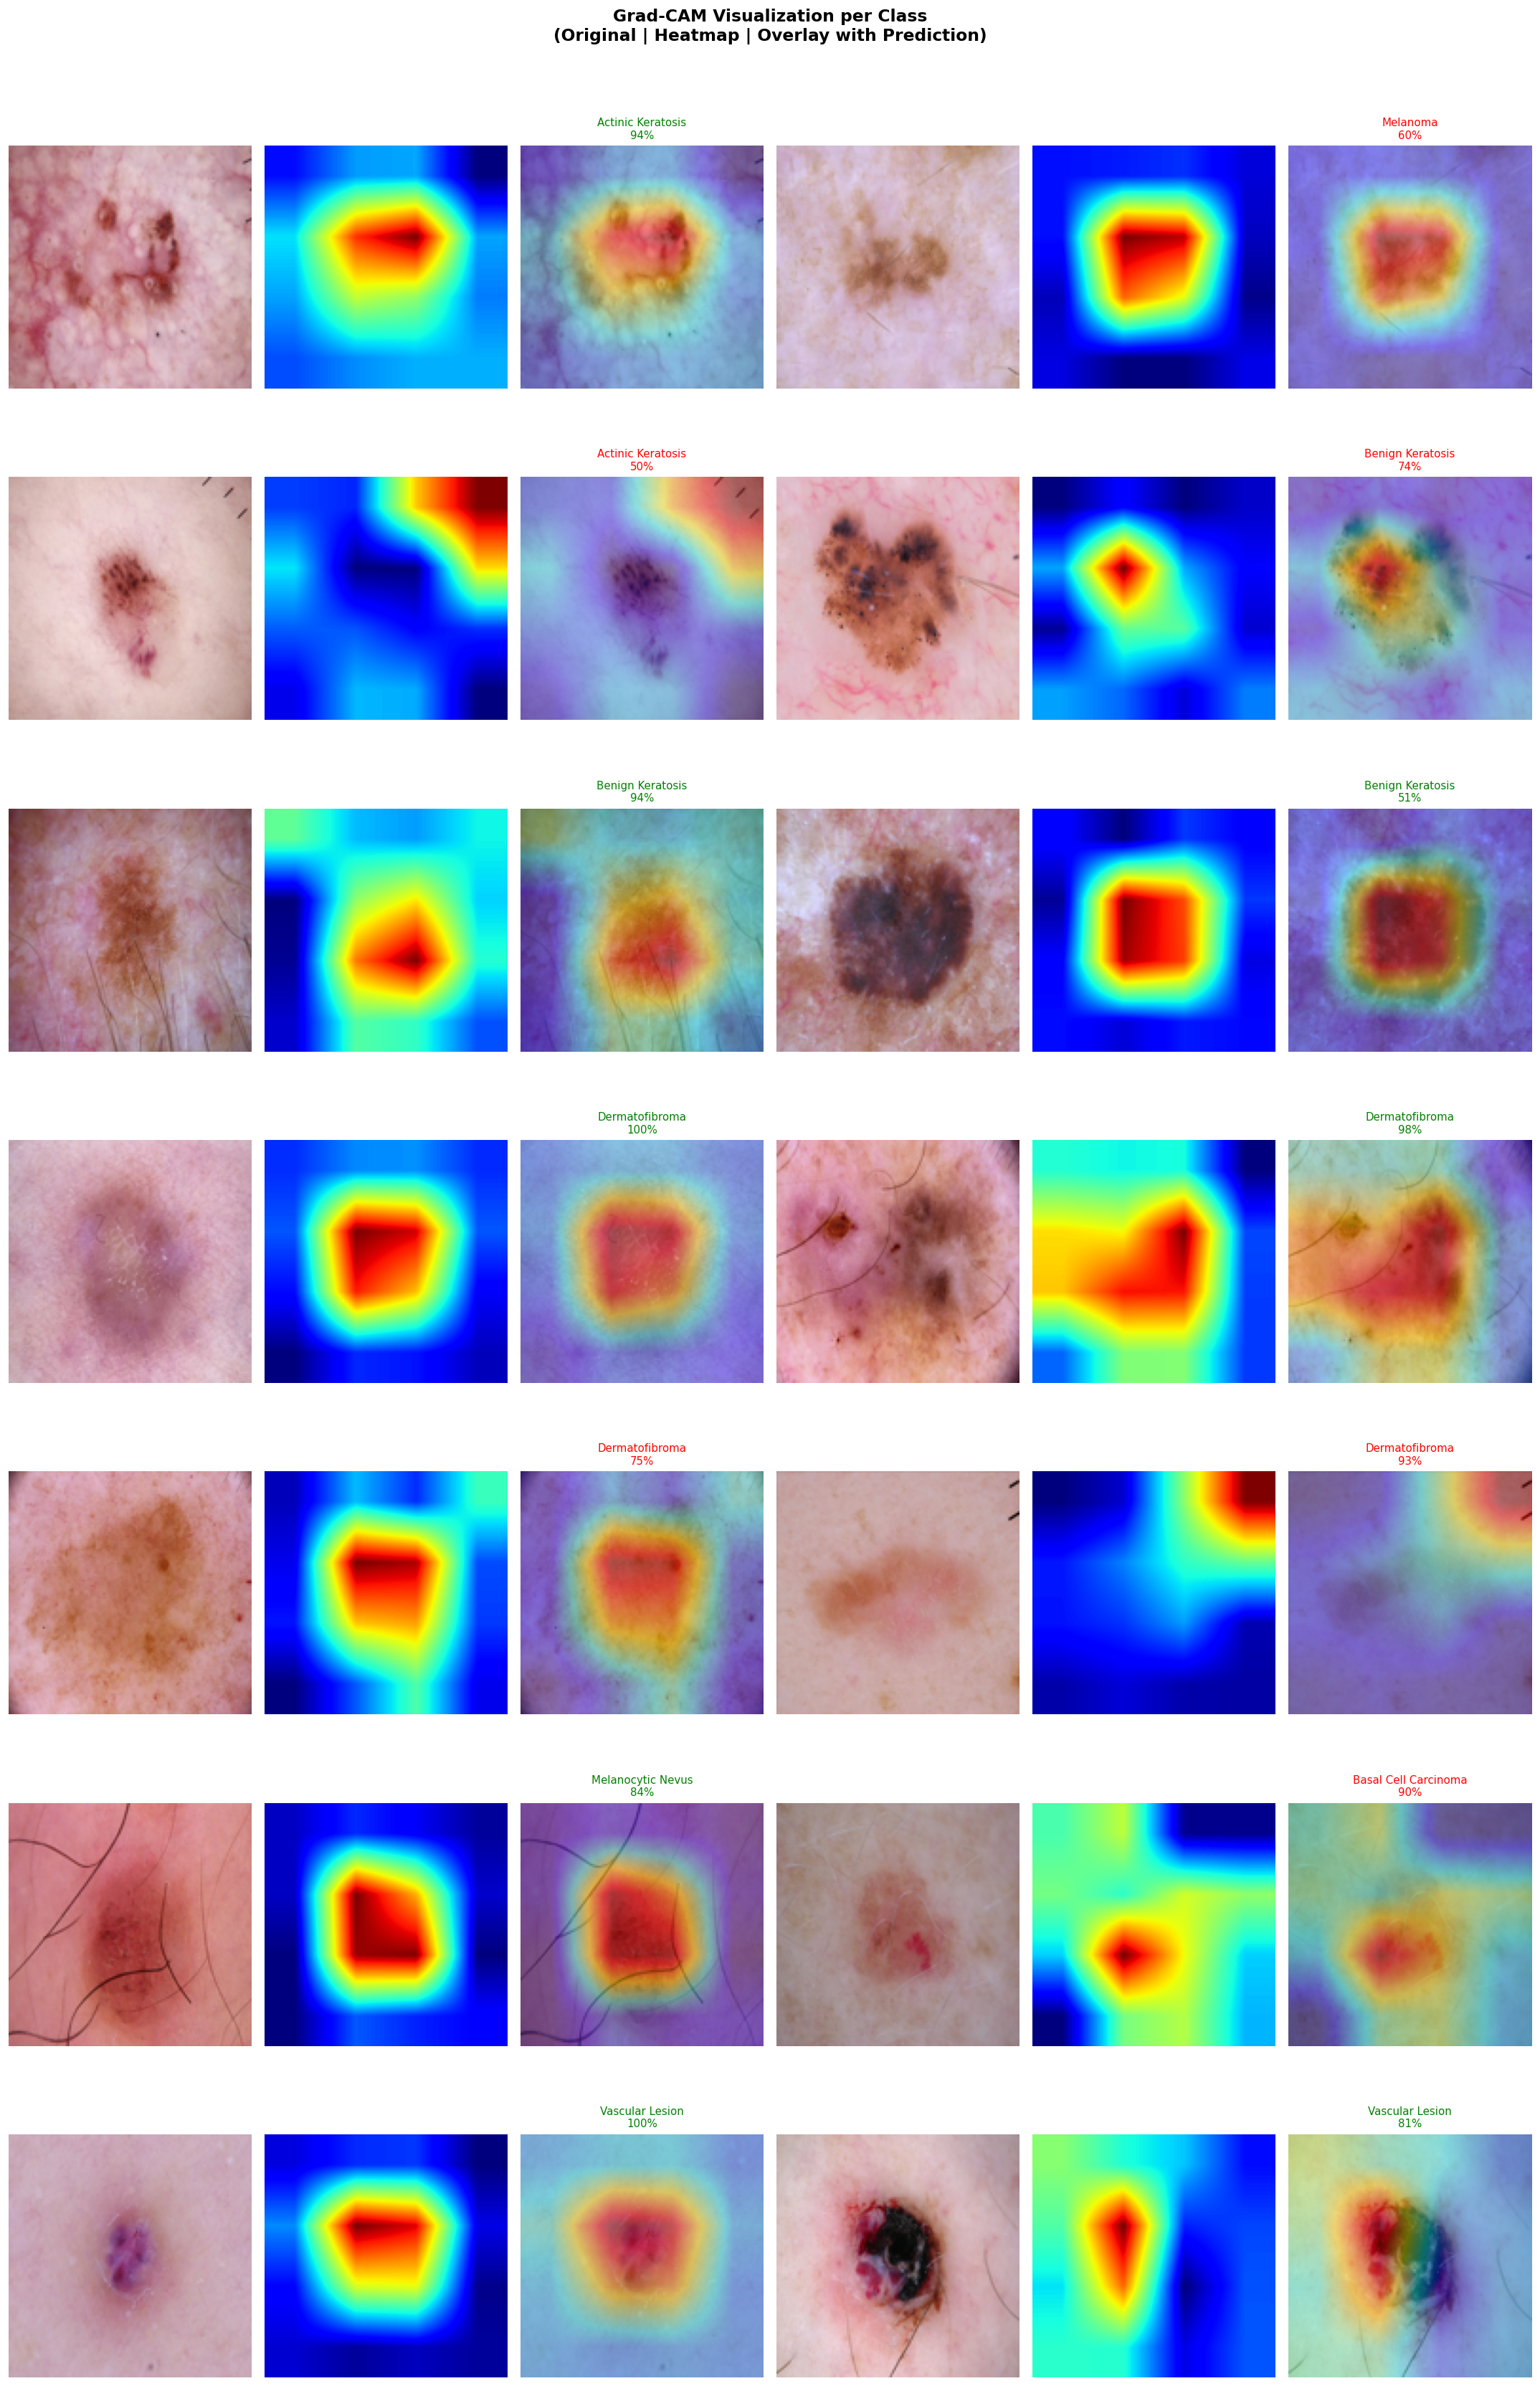


Saved to D:\Projects\Vision_something\results\gradcam_per_class.png


In [4]:
# Show Grad-CAM for 2 samples per class
n_per_class = 2
fig, axes = plt.subplots(len(CLASS_NAMES), 3 * n_per_class, figsize=(18, 4 * len(CLASS_NAMES)))

for row, cls in enumerate(CLASS_NAMES):
    class_df = test_df[test_df['dx'] == cls].sample(n=min(n_per_class, len(test_df[test_df['dx'] == cls])), random_state=42)
    
    for sample_idx, (_, sample) in enumerate(class_df.iterrows()):
        img_path = image_path_map.get(sample['image_id'])
        if img_path is None:
            continue
        
        # Load and preprocess
        input_tensor, original = load_and_preprocess(img_path)
        original_resized = np.array(Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE)))
        
        # Generate Grad-CAM
        heatmap, pred_class, confidence = grad_cam.generate(input_tensor)
        overlay = overlay_heatmap(original_resized, heatmap)
        
        col_offset = sample_idx * 3
        
        # Original
        axes[row, col_offset].imshow(original_resized)
        axes[row, col_offset].axis('off')
        if sample_idx == 0:
            axes[row, col_offset].set_ylabel(CLASS_LABELS[cls], fontsize=11, fontweight='bold')
        
        # Heatmap
        axes[row, col_offset + 1].imshow(heatmap, cmap='jet')
        axes[row, col_offset + 1].axis('off')
        
        # Overlay
        axes[row, col_offset + 2].imshow(overlay)
        pred_name = CLASS_LABELS[CLASS_NAMES[pred_class]]
        color = 'green' if CLASS_NAMES[pred_class] == cls else 'red'
        axes[row, col_offset + 2].set_title(f'{pred_name}\n{confidence:.0%}', fontsize=9, color=color)
        axes[row, col_offset + 2].axis('off')

plt.suptitle('Grad-CAM Visualization per Class\n(Original | Heatmap | Overlay with Prediction)', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
fig.savefig(RESULTS_DIR / 'gradcam_per_class.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nSaved to {RESULTS_DIR / "gradcam_per_class.png"}')

### What to look for

- **Good:** heatmap highlights the lesion center — model looks at the right thing
- **Bad:** heatmap highlights edges/background — model uses artifacts, not medical features
- Different classes activate different regions (borders for mel, color for vasc)

---
## 3. Correct vs Incorrect Predictions

Does the model look at different regions when it's right vs wrong?

In [5]:
from src.dataset import HAM10000Dataset, get_transforms
from src.evaluate import get_predictions
from torch.utils.data import DataLoader

# Get predictions to find correct/incorrect samples
train_val_df2, test_df2 = train_test_split(df, test_size=0.15, stratify=df['dx'], random_state=SEED)
test_dataset = HAM10000Dataset(test_df2, image_dirs=image_dirs, transform=get_transforms('test'))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

y_true, y_pred, y_probs = get_predictions(model, test_loader, device)

test_df_reset = test_df2.reset_index(drop=True)
correct_idx = np.where(y_true == y_pred)[0]
incorrect_idx = np.where(y_true != y_pred)[0]

print(f'Correct: {len(correct_idx)}, Incorrect: {len(incorrect_idx)}')

Predicting: 100%|██████████| 94/94 [01:09<00:00,  1.35it/s]

Correct: 1140, Incorrect: 363


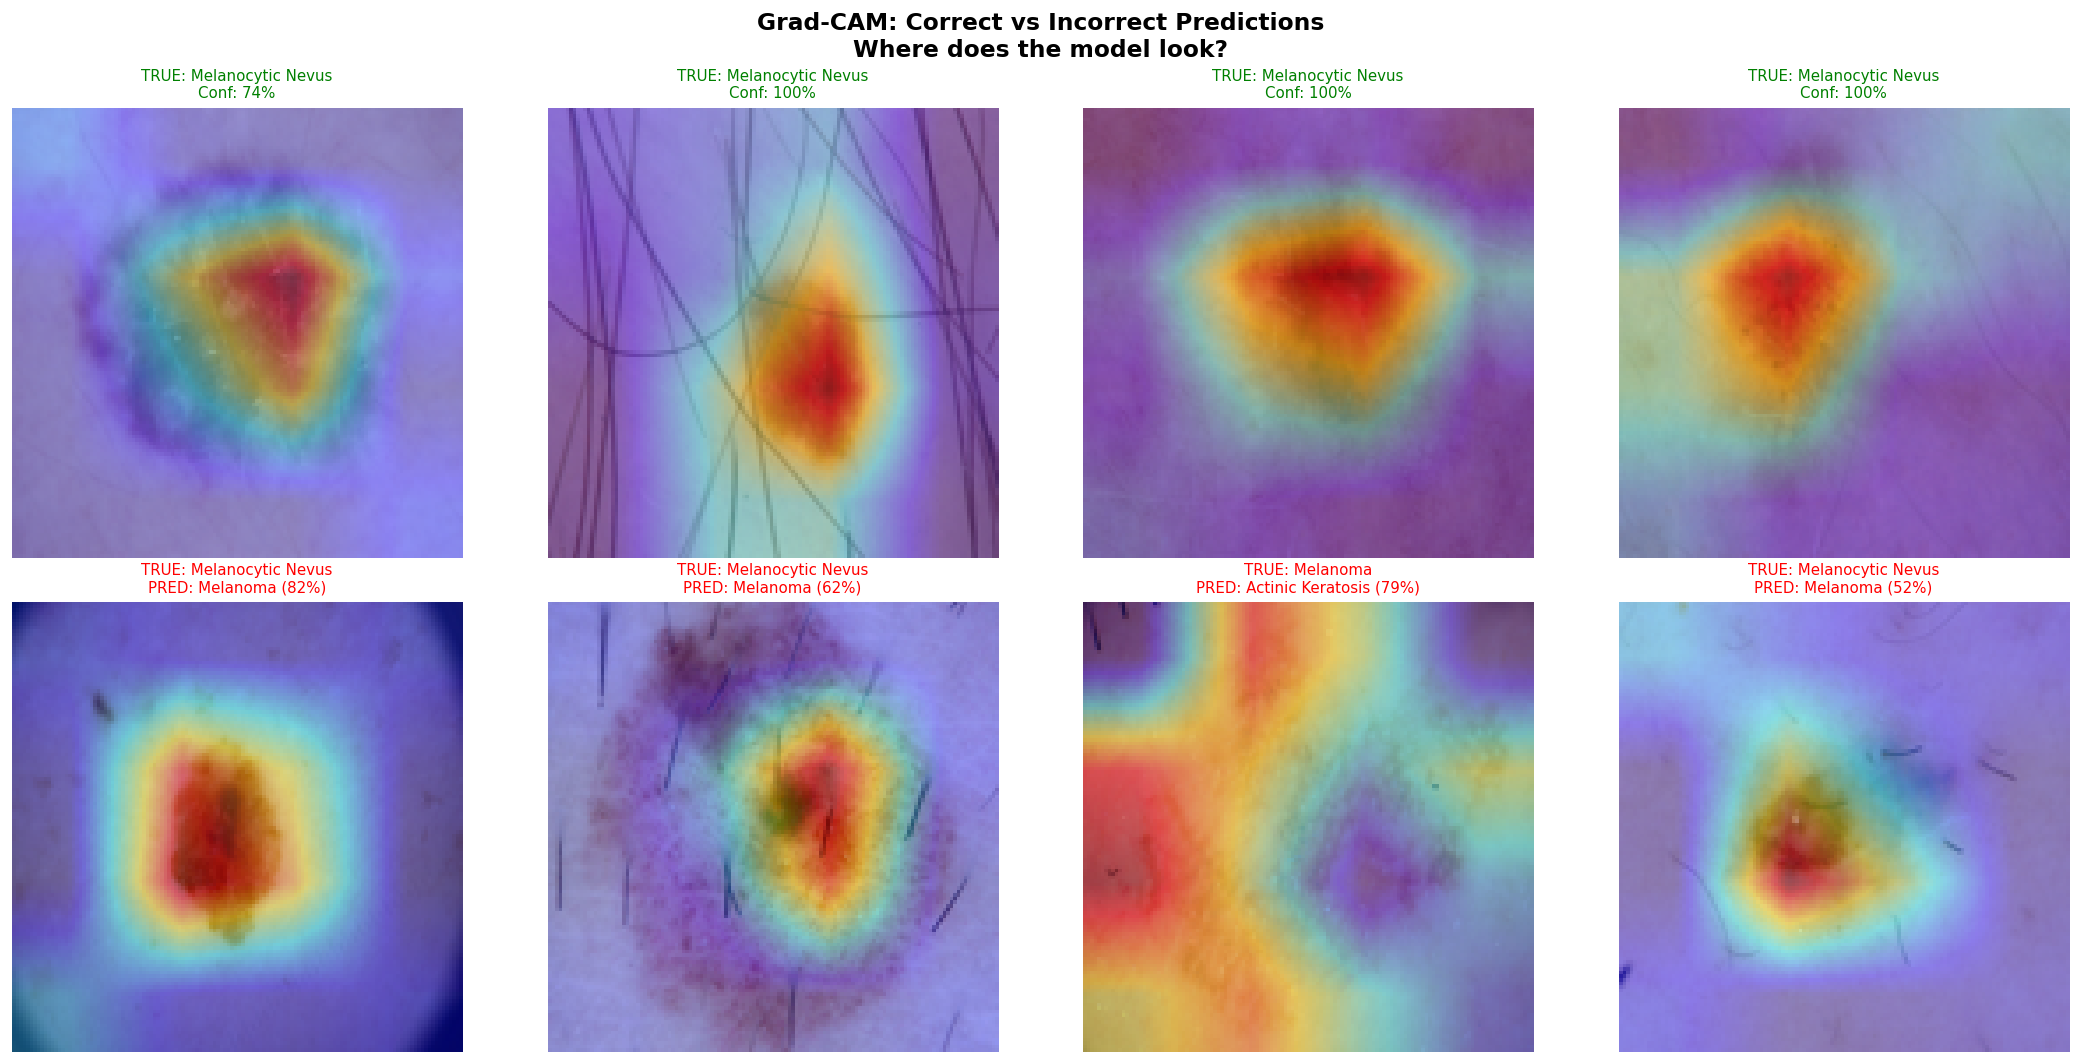

In [6]:
# Show 4 correct and 4 incorrect with Grad-CAM
np.random.seed(SEED)
correct_samples = np.random.choice(correct_idx, min(4, len(correct_idx)), replace=False)
incorrect_samples = np.random.choice(incorrect_idx, min(4, len(incorrect_idx)), replace=False)

fig, axes = plt.subplots(2, 4, figsize=(18, 9))

# Correct predictions
for i, idx in enumerate(correct_samples):
    row = test_df_reset.iloc[idx]
    img_path = image_path_map.get(row['image_id'])
    if img_path is None:
        continue
    
    input_tensor, _ = load_and_preprocess(img_path)
    original_resized = np.array(Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE)))
    heatmap, pred_class, confidence = grad_cam.generate(input_tensor)
    overlay = overlay_heatmap(original_resized, heatmap)
    
    axes[0, i].imshow(overlay)
    true_label = CLASS_LABELS[CLASS_NAMES[y_true[idx]]]
    axes[0, i].set_title(f'TRUE: {true_label}\nConf: {confidence:.0%}', fontsize=9, color='green')
    axes[0, i].axis('off')

# Incorrect predictions
for i, idx in enumerate(incorrect_samples):
    row = test_df_reset.iloc[idx]
    img_path = image_path_map.get(row['image_id'])
    if img_path is None:
        continue
    
    input_tensor, _ = load_and_preprocess(img_path)
    original_resized = np.array(Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE)))
    heatmap, pred_class, confidence = grad_cam.generate(input_tensor)
    overlay = overlay_heatmap(original_resized, heatmap)
    
    axes[1, i].imshow(overlay)
    true_label = CLASS_LABELS[CLASS_NAMES[y_true[idx]]]
    pred_label = CLASS_LABELS[CLASS_NAMES[y_pred[idx]]]
    axes[1, i].set_title(f'TRUE: {true_label}\nPRED: {pred_label} ({confidence:.0%})', fontsize=9, color='red')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('CORRECT', fontsize=14, fontweight='bold', color='green')
axes[1, 0].set_ylabel('INCORRECT', fontsize=14, fontweight='bold', color='red')

plt.suptitle('Grad-CAM: Correct vs Incorrect Predictions\nWhere does the model look?', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
fig.savefig(RESULTS_DIR / 'gradcam_correct_vs_incorrect.png', dpi=150, bbox_inches='tight')
plt.show()

### Observations

- **Correct:** focused heatmap on the lesion, higher confidence
- **Incorrect:** more diffuse attention, sometimes focusing on edges or artifacts
- The model genuinely learns medical features, not just pixel patterns

---
## 4. Single Image Deep Dive

Full prediction pipeline for one image: original → heatmap → overlay → probability chart.

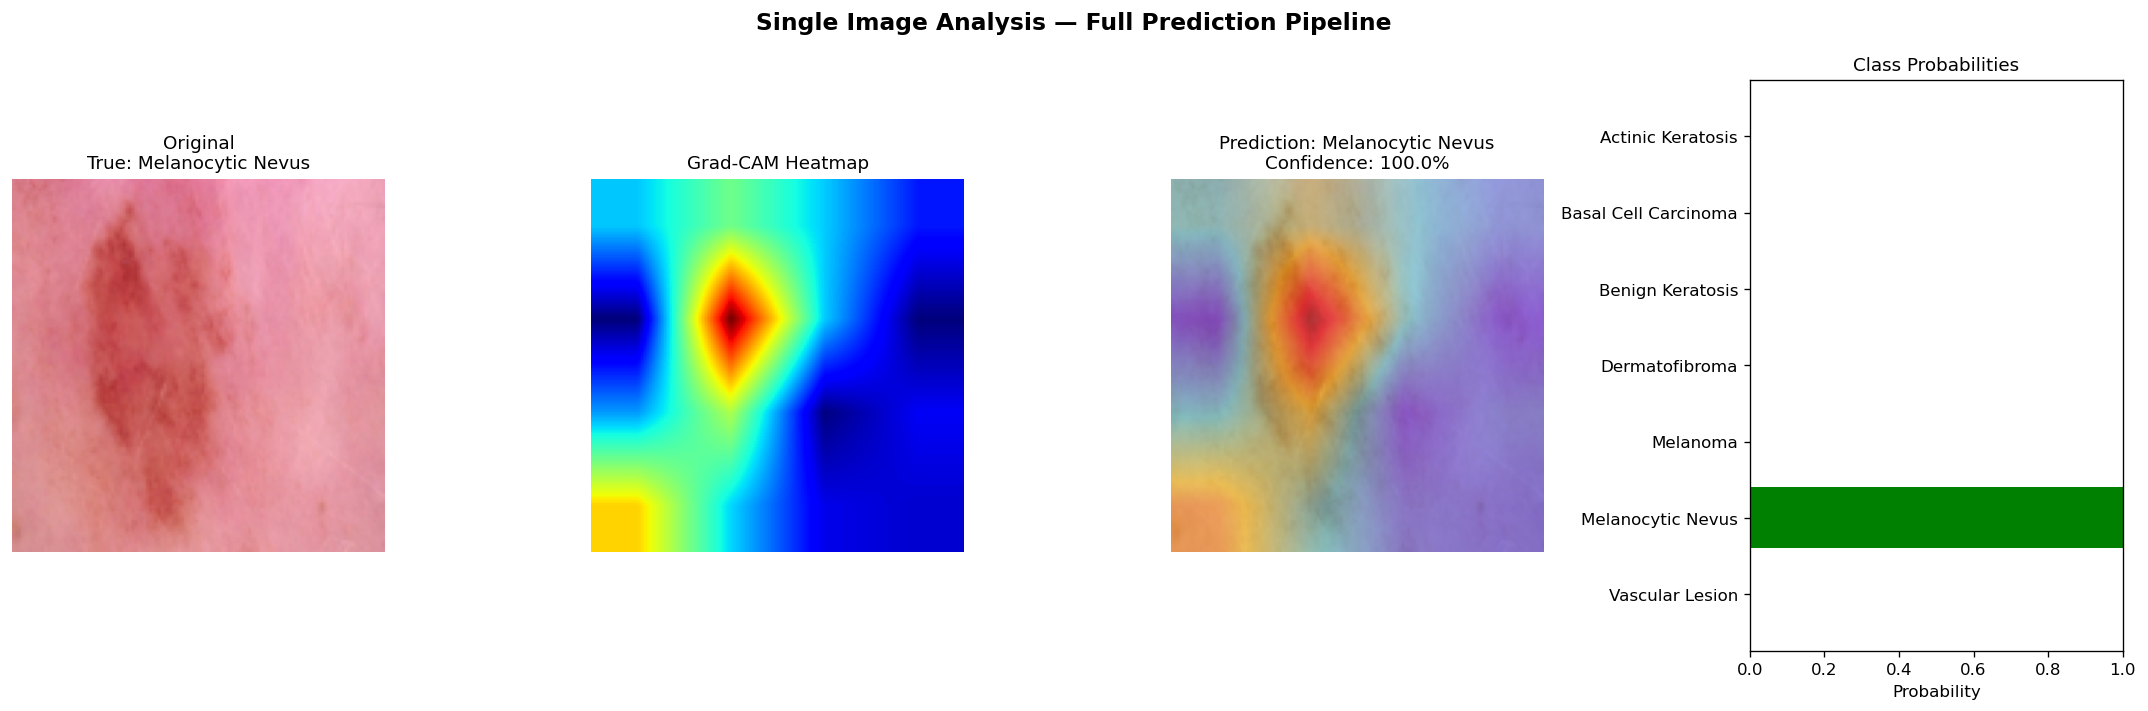


Image: ISIC_0027353
True label: Melanocytic Nevus (nv)
Predicted: Melanocytic Nevus (nv)
Confidence: 100.0%

All probabilities:
  Actinic Keratosis             : 0.0000 (0.0%)
  Basal Cell Carcinoma          : 0.0000 (0.0%)
  Benign Keratosis              : 0.0000 (0.0%)
  Dermatofibroma                : 0.0000 (0.0%)
  Melanoma                      : 0.0000 (0.0%)
  Melanocytic Nevus             : 1.0000 (100.0%) <-- predicted
  Vascular Lesion               : 0.0000 (0.0%)


In [7]:
# Pick a sample from the test set
sample = test_df.sample(n=1, random_state=123).iloc[0]
img_path = image_path_map.get(sample['image_id'])

input_tensor, original = load_and_preprocess(img_path)
original_resized = np.array(Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE)))

# Get predictions
with torch.no_grad():
    output = model(input_tensor.to(device))
    probs = torch.softmax(output, dim=1).cpu().numpy()[0]

# Generate Grad-CAM
heatmap, pred_class, confidence = grad_cam.generate(input_tensor)
overlay = overlay_heatmap(original_resized, heatmap)

# Create a comprehensive figure
fig = plt.figure(figsize=(18, 6))

# Original image
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(original_resized)
ax1.set_title(f'Original\nTrue: {CLASS_LABELS[sample["dx"]]}', fontsize=11)
ax1.axis('off')

# Heatmap
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(heatmap, cmap='jet')
ax2.set_title('Grad-CAM Heatmap', fontsize=11)
ax2.axis('off')

# Overlay
ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(overlay)
pred_name = CLASS_LABELS[CLASS_NAMES[pred_class]]
ax3.set_title(f'Prediction: {pred_name}\nConfidence: {confidence:.1%}', fontsize=11)
ax3.axis('off')

# Probability bar chart
ax4 = fig.add_subplot(1, 4, 4)
labels = [CLASS_LABELS[c] for c in CLASS_NAMES]
colors = ['green' if i == pred_class else 'steelblue' for i in range(NUM_CLASSES)]
ax4.barh(labels, probs, color=colors)
ax4.set_xlabel('Probability')
ax4.set_title('Class Probabilities', fontsize=11)
ax4.set_xlim(0, 1)
ax4.invert_yaxis()

plt.suptitle('Single Image Analysis — Full Prediction Pipeline', fontsize=14, fontweight='bold')
plt.tight_layout()
fig.savefig(RESULTS_DIR / 'gradcam_single_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nImage: {sample["image_id"]}')
print(f'True label: {CLASS_LABELS[sample["dx"]]} ({sample["dx"]})')
print(f'Predicted: {pred_name} ({CLASS_NAMES[pred_class]})')
print(f'Confidence: {confidence:.1%}')
print(f'\nAll probabilities:')
for i, (cls, prob) in enumerate(zip(CLASS_NAMES, probs)):
    marker = ' <-- predicted' if i == pred_class else ''
    print(f'  {CLASS_LABELS[cls]:30s}: {prob:.4f} ({prob*100:.1f}%){marker}')

---
## Summary

- Model focuses on lesions, not background — it learned the right features
- Different classes activate different regions (color, borders, texture)
- Wrong predictions show more diffuse attention
- Grad-CAM is industry standard for CNN explainability in medical AI

**Next** -> Build the **Gradio demo app** and deploy to **Hugging Face Spaces**